In [1]:
import os
import sys
sys.path.insert(0,os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir, os.pardir, os.pardir, os.pardir, os.pardir)))
sys.path.insert(0,os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir, os.pardir, os.pardir, os.pardir)))

## Constant calibration

We recalibrate ASCs and thresholds to make the model suitable for forecasting. I had to add a learning rate in the formula of Train because otherwise, it could jump back and forth over the solution, without reaching the tolerance (especially with thresholds). And I also increased the tolerance by a factor of 2 every 100 iterations.

In [53]:
%load_ext autoreload
%autoreload 2
from src.simba.mobi.choice.models.homeoffice.constants_calibration import calibrate_constants

models = ["rumboost_all_data", "lin_rumboost_all_data", ] #"dcm_all_data", "dcm", "rumboost", "lin_rumboost"
intensity= [20, 0]
n_runs = 10

for m in models:
    for i in intensity:
        for n in range(n_runs):
            if "all_data" in m and n != 0:
                continue
            model, data = calibrate_constants(m, i, n, tol=1e-3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
threshold 0 calibrated for model rumboost_all_data and run 0
threshold 1 calibrated for model rumboost_all_data and run 0
threshold 2 calibrated for model rumboost_all_data and run 0
threshold 3 calibrated for model rumboost_all_data and run 0
threshold 4 calibrated for model rumboost_all_data and run 0
ASC calibrated for model rumboost_all_data and run 0
threshold 0 calibrated for model lin_rumboost_all_data and run 0
threshold 1 calibrated for model lin_rumboost_all_data and run 0
threshold 2 calibrated for model lin_rumboost_all_data and run 0
threshold 3 calibrated for model lin_rumboost_all_data and run 0
threshold 4 calibrated for model lin_rumboost_all_data and run 0
ASC calibrated for model lin_rumboost_all_data and run 0


## Model fit (Full fata)

### Results with constants non calibrated

In [54]:
#load results
import pandas as pd
import numpy as np
import os
results_directory = os.getcwd() + r"\homeoffice\models\estimation\2021"
n_runs = 1
model = ["dcm_all_data", "rumboost_all_data", "lin_rumboost_all_data"]
intensity = [20, 0]

indices = [
    ('dcm', 'teleworking intensity (20 %)', 'train'),
    ('dcm', 'teleworking possibility', 'train'),
    ('rumboost', 'teleworking intensity (20 %)', 'train'),
    ('rumboost', 'teleworking possibility', 'train'),
    ('lin_rumboost', 'teleworking intensity (20 %)', 'train'),
    ('lin_rumboost', 'teleworking possibility', 'train'),
]
df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
std_df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
for m in model:
    m_name = m.replace("_all_data", "")
    for i in intensity:
        data = []
        for j in range(n_runs):
            modelling_task = "intensity" if i > 0 else "possibility"
            results_file = results_directory + f"/{m}/{modelling_task}/metrics_seed{j}.csv"
            if i > 0 and "dcm" in m:
                index = ["train"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif i > 0:
                index = ["train_final"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif "dcm" in m:
                index = ["train"]
                cols = ["CEL"]
            else:
                index = ["train_final"]
                cols = ["CEL"]
            with open(results_file, "r") as f:
                data.append(pd.read_csv(f, index_col=0).loc[index, :].values)

        if i == 20:
            iterables = [[m_name], [f"teleworking intensity (20 %)"], ["train"]]
        elif i == 0:
            iterables = [[m_name], [f"teleworking possibility"], ["train"]]
        
        mulitindex = pd.MultiIndex.from_product(iterables, names=["model", "type", "task"])

        # df.join(pd.DataFrame(np.array(data).mean(axis=0), index=mulitindex, columns=cols), on=cols)
        df.loc[mulitindex, cols] = np.array(data).mean(axis=0)
        # std_df.loc[mulitindex, cols] = np.array(data).std(axis=0)

In [55]:
formatted_df = df.pivot_table(index=["type", "model"], columns="task").map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN")
formatted_df.replace("NaN", "-", inplace=True)
formatted_df

CEL   EMAE   EMSE    MAE    MSE
task                                       train  train  train  train  train
type                         model                                          
teleworking intensity (20 %) dcm           1.647  1.877  5.763  1.468  2.886
                             lin_rumboost  1.640  1.861  5.693  1.455  2.842
                             rumboost      1.636  1.861  5.690  1.454  2.818
teleworking possibility      dcm           0.559      -      -      -      -
                             lin_rumboost  0.554      -      -      -      -
                             rumboost      0.552      -      -      -      -

### Results with constants calibrated

In [56]:
#load results
import pandas as pd
import numpy as np
import os
results_directory = os.getcwd() + r"\homeoffice\models\estimation\2021"
n_runs = 1
model = ["dcm_all_data", "rumboost_all_data", "lin_rumboost_all_data"]
intensity = [20, 0]

indices = [
    ('dcm', 'teleworking intensity (20 %)', 'train'),
    ('dcm', 'teleworking possibility', 'train'),
    ('rumboost', 'teleworking intensity (20 %)', 'train'),
    ('rumboost', 'teleworking possibility', 'train'),
    ('lin_rumboost', 'teleworking intensity (20 %)', 'train'),
    ('lin_rumboost', 'teleworking possibility', 'train'),
]
df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
std_df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
for m in model:
    m_name = m.replace("_all_data", "")
    for i in intensity:
        data = []
        for j in range(n_runs):
            modelling_task = "intensity" if i > 0 else "possibility"
            results_file = results_directory + f"/{m}/{modelling_task}/metrics_seed{j}_calibrated.csv"
            if i > 0 and "dcm" in m:
                index = ["train"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif i > 0:
                index = ["train"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif "dcm" in m:
                index = ["train"]
                cols = ["CEL"]
            else:
                index = ["train"]
                cols = ["CEL"]
            with open(results_file, "r") as f:
                data.append(pd.read_csv(f, index_col=0).loc[index, :].values)

        if i == 20:
            iterables = [[m_name], [f"teleworking intensity (20 %)"], ["train"]]
        elif i == 0:
            iterables = [[m_name], [f"teleworking possibility"], ["train"]]
        
        mulitindex = pd.MultiIndex.from_product(iterables, names=["model", "type", "task"])

        # df.join(pd.DataFrame(np.array(data).mean(axis=0), index=mulitindex, columns=cols), on=cols)
        df.loc[mulitindex, cols] = np.array(data).mean(axis=0)
        # std_df.loc[mulitindex, cols] = np.array(data).std(axis=0)

In [57]:
formatted_df = df.pivot_table(index=["type", "model"], columns="task").map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN")
formatted_df.replace("NaN", "-", inplace=True)
formatted_df

CEL   EMAE   EMSE    MAE    MSE
task                                       train  train  train  train  train
type                         model                                          
teleworking intensity (20 %) dcm           1.663  1.911  5.953  1.482  2.965
                             lin_rumboost  1.660  1.900  5.902  1.474  2.947
                             rumboost      1.655  1.899  5.896  1.471  2.913
teleworking possibility      dcm           0.559      -      -      -      -
                             lin_rumboost  0.566      -      -      -      -
                             rumboost      0.564      -      -      -      -

Note for the paper: 
- This is the value on full data for training. RUMBoost estimated with 5-fold CV.
- The models are compared with 3 probabilitic metrics (Cross-Entropy Loss, Expected Mean Absolute Error, Expected Mean Squared Error) and two regression metrics (Mean Absolute Error, Mean Squared Error)
- There are three models: RUMBoost Linear RUMBoost and an Ordinal Logit, applied to two choices situations: 
    1. Intensity of teleworking, defined at the 20% thresholds,
    2. Possibility of teleworking, this is a binary classification problem
- For MAE and MSE, the ascs need to be recomputed since the models have been trained with maximum likelihood / cross-entropy loss, and ascs are implicitly contained within the thresholds. For MSE, asc is the mean of residuals, and for MAE it is the median of residuals (formulas to add in the methodology of the paper). They are reestimated only with the training set.


## Parameters

In [58]:
def transform_linweights_to_weights(lin_weights):
    """
    Transforms linear rumboost weights to rumboost weights.
    :param lin_weights: Linear weights
    :return: Weights
    """
    new_weights = {}
    for value in lin_weights.values():
        if "0" not in new_weights:
            new_weights["0"] = {}
        for k, v in value.items():
            new_weights["0"][k] = v
    return new_weights

In [66]:
# load results
import pandas as pd
import numpy as np
import lightgbm
import torch
import glob
from src.simba.mobi.rumboost.rumboost import RUMBoost
from src.simba.mobi.rumboost.utility_plotting import (
    weights_to_plot_v2,
    non_lin_function,
)

results_directory = os.getcwd() + r"\homeoffice\models\estimation\2021"
n_runs = 1
model = ["dcm_all_data", "rumboost_all_data", "lin_rumboost_all_data"]
intensity = [20, 0]

indices = [
    ("dcm", "teleworking intensity (20 %)"),
    ("dcm", "teleworking possibility"),
    (
        "rumboost",
        "teleworking intensity (20 %)",
    ),
    ("rumboost", "teleworking possibility"),
    ("lin_rumboost", "teleworking intensity (20 %)"),
    ("lin_rumboost", "teleworking possibility"),
]

index = [
    "alternative_specific_constant",
    "b_executives_21",
    "b_falc_id_NA",
    "b_general_abo_halbtax",
    "b_german_speaking",
    "b_hh_income_8000_or_less",
    "b_hh_income_na",
    "b_hh_income_2000_to_4000",
    "b_hh_income_4001_to_6000",
    "b_hh_income_6001_to_8000",
    "b_home_work_distance_car_NA",
    "b_is_falc_id_6to9_1_21",
    "b_is_production_1_21",
    "b_is_wohlesale_1_21",
    "b_no_post_school_education",
    "b_number_of_children",
    "b_number_of_children_NA",
    "b_secondary_education",
    "b_single_houshold",
    "b_tertiary_education",
    "beta_accsib_home_not_NA_5_10_21",
    "beta_age_21_18_35",
    "beta_home_work_distance_car_0_0.15",
    "beta_work_percentage_95_101_20_21",
    "b_nb_of_cars_not_NA",
    "b_car_avail_not_NA_always",
    "b_car_avail_not_NA_on_demand",
    "b_work_time_flexibility_NA",
    "b_work_time_flexibility_not_NA_fixed",
    "b_work_parking_not_NA_free",
    "b_is_swiss",
    "b_typology_work_not_NA_urban",
    "b_pt_travel_times_not_NA",
    "b_pt_access_times_not_NA",
    "b_pt_egress_times_not_NA",
    "b_n_transfers_not_NA",
    "b_pt_tt_or_transfers_NA",
    "tau_1",
    "tau_1_diff_1",
    "tau_1_diff_2",
    "tau_1_diff_3",
    "tau_1_diff_4",
]

rename_params = {
    "home_work_distance_car": "beta_home_work_distance_car_0_0.15",
    "accsib_home_not_NA_21": "beta_accsib_home_not_NA_5_10_21",
    "secondary_education": "b_secondary_education",
    "work_percentage_21": "beta_work_percentage_95_101_20_21",
    "business_sector_wholesale_21": "b_is_wohlesale_1_21",
    "number_of_children_not_NA": "b_number_of_children",
    "business_sector_production_21": "b_is_production_1_21",
    "tertiary_education": "b_tertiary_education",
    "fal_id_NA": "b_falc_id_NA",
    "hh_income_6001_to_8000": "b_hh_income_6001_to_8000",
    "age_21": "beta_age_21_18_35",
    "executives_21": "b_executives_21",
    "german_speaking": "b_german_speaking",
    "no_post_school_educ": "b_no_post_school_education",
    "hh_income_2000_to_4000": "b_hh_income_2000_to_4000",
    "hh_income_4001_to_6000": "b_hh_income_4001_to_6000",
    "hh_income_na": "b_hh_income_na",
    "single_household": "b_single_houshold",
    "is_falc_id_6to9_21": "b_is_falc_id_6to9_1_21",
    "is_swiss": "b_is_swiss",
    "typology_work_not_NA_urban": "b_typology_work_not_NA_urban",
    "car_avail_not_NA_always": "b_car_avail_not_NA_always",
    "car_avail_not_NA_on_demand": "b_car_avail_not_NA_on_demand",
    "work_time_flexibility_NA": "b_work_time_flexibility_NA",
    "work_time_flexibility_not_NA_fixed": "b_work_time_flexibility_not_NA_fixed",
    "work_parking_not_NA_free": "b_work_parking_not_NA_free",
    "pt_tt_or_transfers_NA": "b_pt_tt_or_transfers_NA",
    "pt_travel_times_not_NA": "b_pt_travel_times_not_NA",
    "pt_access_times_not_NA": "b_pt_access_times_not_NA",
    "pt_egress_times_not_NA": "b_pt_egress_times_not_NA",
    "n_transfers_not_NA": "b_n_transfers_not_NA",
    "nb_of_cars_not_NA": "b_nb_of_cars_not_NA",
}

nonlin_params = [
    "beta_age_21_18_35",
    "beta_accsib_home_not_NA_5_10_21",
    "beta_home_work_distance_car_0_0.15",
    "b_number_of_children",
    "beta_work_percentage_95_101_20_21",
    "b_pt_travel_times_not_NA",
    "b_pt_access_times_not_NA",
    "b_pt_egress_times_not_NA",
    "b_n_transfers_not_NA",
    "b_nb_of_cars_not_NA",
]  # nonlinear parameters in the RUMBoost model
nonlin_params_name = [
    "age_21",
    "accsib_home_not_NA_21",
    "home_work_distance_car",
    "number_of_children_not_NA",
    "work_percentage_21",
    "pt_travel_times_not_NA",
    "pt_access_times_not_NA",
    "pt_egress_times_not_NA",
    "n_transfers_not_NA",
    "nb_of_cars_not_NA",
]
thresholds_names = [
    "tau_1",
    "tau_1_diff_1",
    "tau_1_diff_2",
    "tau_1_diff_3",
    "tau_1_diff_4",
]
col_names_ordinal = [
    "home_work_distance_car",
    "accsib_home_not_NA_21",
    "secondary_education",
    "work_percentage_21",
    "business_sector_wholesale_21",
    "number_of_children_not_NA",
    "business_sector_production_21",
    "tertiary_education",
    "fal_id_NA",
    "hh_income_6001_to_8000",
    "age_21",
    "executives_21",
    "german_speaking",
    "no_post_school_educ",
    "hh_income_2000_to_4000",
    "hh_income_4001_to_6000",
    "hh_income_na",
    "single_household",
    "is_falc_id_6to9_21",
    "is_swiss",
    "typology_work_not_NA_urban",
    "car_avail_not_NA_always",
    "car_avail_not_NA_on_demand",
    "work_time_flexibility_NA",
    "work_time_flexibility_not_NA_fixed",
    "work_parking_not_NA_free",
    "pt_tt_or_transfers_NA",
    "pt_travel_times_not_NA",
    "pt_access_times_not_NA",
    "pt_egress_times_not_NA",
    "n_transfers_not_NA",
    "nb_of_cars_not_NA",
    "single_parent_with_children",
    "hh_income_less_than_2000",
    "general_abo_halbtax",
    "falc_id_NA",
    "nb_of_cars_NA",
]
col_names_binary = [
    "home_work_distance_car",
    "accsib_home_not_NA_21",
    "secondary_education",
    "work_percentage_21",
    "business_sector_wholesale_21",
    "number_of_children_not_NA",
    "business_sector_production_21",
    "tertiary_education",
    "fal_id_NA",
    "hh_income_6001_to_8000",
    "age_21",
    "executives_21",
    "german_speaking",
    "no_post_school_educ",
    "hh_income_2000_to_4000",
    "hh_income_4001_to_6000",
    "hh_income_na",
    "single_household",
    "is_falc_id_6to9_21",
    "single_parent_with_children",
    "number_of_children_NA",
    "hh_income_less_than_2000",
    "general_abo_halbtax",
    "home_work_distance_car_NA",
    "falc_id_NA",
    "business_sector_agriculture_21",
]

df = pd.DataFrame(
    {}, columns=pd.MultiIndex.from_tuples(indices, names=["model", "type"]), index=index
)
std_df = pd.DataFrame(
    {}, columns=pd.MultiIndex.from_tuples(indices, names=["model", "type"]), index=index
)
sign_df = pd.DataFrame(
    {}, columns=pd.MultiIndex.from_tuples(indices, names=["model", "type"]), index=index
)
all_weights = {}

for m in model:
    m_name = m.replace("_all_data", "")
    for i in intensity:
        if i == 20:
            cols = pd.MultiIndex.from_product(
                [[m_name], ["teleworking intensity (20 %)"]]
            )
        elif i == 0:
            cols = pd.MultiIndex.from_product([[m_name], ["teleworking possibility"]])
        data = []
        significance = []
        for j in range(n_runs):
            modelling_task = "intensity" if i > 0 else "possibility"
            if "dcm" in m:
                results_file = (
                    results_directory
                    + f"/{m}/{modelling_task}/parameters_seed{j}_calibrated.csv"
                )
                with open(results_file, "r") as f:
                    df_dcm = pd.read_csv(f, index_col=0)
                    index = df_dcm.index
                    data.append(df_dcm["Value"].values)
                    significance.append(df_dcm["Rob. p-value"].values)

            else:
                results_file = (
                    results_directory
                    + f"/{m}/{modelling_task}/model_seed{j}_calibrated.json"
                )
                rum_model = RUMBoost(model_file=results_file)
                weights = weights_to_plot_v2(rum_model)
                if "lin" in m:
                    weights = transform_linweights_to_weights(weights)

                weights = weights["0"]

                binary_variables = [
                    (
                        weights[f]["Histogram values"][1]
                        - weights[f]["Histogram values"][0]
                        if f in weights.keys()
                        and len(weights[f]["Splitting points"]) == 1
                        else 0
                    )
                    for f in rename_params.keys()
                ]
                index = list(rename_params.values())

                df_rum = pd.DataFrame(binary_variables, columns=cols, index=index)

                df_rum.loc[nonlin_params, :] = -99

                if i > 0:
                    dummy_data = lightgbm.Dataset(
                        pd.DataFrame(
                            np.zeros((1, len(col_names_ordinal))),
                            columns=col_names_ordinal,
                        ),
                        free_raw_data=False,
                    )
                    asc = rum_model.predict(dummy_data, utilities=True)[0][0]
                else:
                    dummy_data = lightgbm.Dataset(
                        pd.DataFrame(
                            np.zeros((1, len(col_names_binary))),
                            columns=col_names_binary,
                        ),
                        free_raw_data=False,
                    )
                    asc = rum_model.predict(dummy_data, utilities=True)[0][0]
                if isinstance(asc, torch.Tensor):
                    asc = asc.item()
                if i > 0:
                    df_rum.loc["tau_1", :] = rum_model.thresholds[0] - asc
                    for k, t in enumerate(np.diff(rum_model.thresholds)):
                        df_rum.loc[thresholds_names[k + 1], :] = t
                    index = index + thresholds_names[: len(rum_model.thresholds)]
                else:
                    df_rum.loc["alternative_specific_constant", :] = asc
                    index = index + ["alternative_specific_constant"]

                data.append(df_rum.values)

        df.loc[index, cols] = np.array(data).mean(axis=0)
        # std_df.loc[index, cols] = np.array(data).std(axis=0)
        if "dcm" in m:
            sign_df.loc[index, cols] = np.array(significance).mean(axis=0)

In [67]:
pd.set_option('future.no_silent_downcasting', True)

# formatted_df = df.map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN") + " (± " + std_df.map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN") + ")" + sign_df.map(lambda x: "***" if x < 0.01 else "**" if x < 0.05 else "*" if x < 0.1 else "")
formatted_df = df.map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN") + sign_df.map(lambda x: "***" if x < 0.01 else "**" if x < 0.05 else "*" if x < 0.1 else "")

formatted_df.replace("NaN", "-").replace("-99.000", "Non-linear").replace("0.000", "-")


model                                                         dcm  \
type                                 teleworking intensity (20 %)   
alternative_specific_constant                                   -   
b_executives_21                                         -0.115***   
b_falc_id_NA                                             0.695***   
b_general_abo_halbtax                                       0.024   
b_german_speaking                                        0.180***   
b_hh_income_8000_or_less                                -0.122***   
b_hh_income_na                                              0.072   
b_hh_income_2000_to_4000                                        -   
b_hh_income_4001_to_6000                                        -   
b_hh_income_6001_to_8000                                        -   
b_home_work_distance_car_NA                                     -   
b_is_falc_id_6to9_1_21                                   0.463***   
b_is_production_1_21                                     0.334***   
b_is_wohlesale_1_21                                      0.734***   
b_no_post_school_education                                 -0.024   
b_number_of_children                                    -0.113***   
b_number_of_children_NA                                         -   
b_secondary_education                                   -0.191***   
b_single_houshold                                       -0.138***   
b_tertiary_education                                    -0.300***   
beta_accsib_home_not_NA_5_10_21                          0.043***   
beta_age_21_18_35                                        0.024***   
beta_home_work_distance_car_0_0.15                              -   
beta_work_percentage_95_101_20_21                        0.040***   
b_nb_of_cars_not_NA                                     -0.061***   
b_car_avail_not_NA_always                                -0.111**   
b_car_avail_not_NA_on_demand                              -0.101*   
b_work_time_flexibility_NA                              -0.214***   
b_work_time_flexibility_not_NA_fixed                    -0.572***   
b_work_parking_not_NA_free                              -0.214***   
b_is_swiss                                              -0.249***   
b_typology_work_not_NA_urban                             0.165***   
b_pt_travel_times_not_NA                                 0.261***   
b_pt_access_times_not_NA                                    0.060   
b_pt_egress_times_not_NA                                 0.601***   
b_n_transfers_not_NA                                       -0.009   
b_pt_tt_or_transfers_NA                                  0.854***   
tau_1                                                   -1.363***   
tau_1_diff_1                                             1.745***   
tau_1_diff_2                                             0.528***   
tau_1_diff_3                                             0.582***   
tau_1_diff_4                                             0.435***   

model                                                         \
type                                 teleworking possibility   
alternative_specific_constant                      -1.851***   
b_executives_21                                     0.768***   
b_falc_id_NA                                        1.376***   
b_general_abo_halbtax                               0.314***   
b_german_speaking                                   0.302***   
b_hh_income_8000_or_less                           -0.645***   
b_hh_income_na                                     -0.493***   
b_hh_income_2000_to_4000                                   -   
b_hh_income_4001_to_6000                                   -   
b_hh_income_6001_to_8000                                   -   
b_home_work_distance_car_NA                          0.301**   
b_is_falc_id_6to9_1_21                              1.437***   
b_is_production_1_21                                0.949***   
b_i

Note for the paper:

- 3 stars indicate a significant parameter at the 99% level, 2 stars at the 95% level, and 1 star at 90% level. No star means that the parameter has not been significant on average.
- The thresholds are, apart from the first one, the difference in between the subsequent ones.

## Model fit on 10 random split of the data

### Results with constants non calibrated

In [68]:
#load results
import pandas as pd
import numpy as np
import os
results_directory = os.getcwd() + r"\homeoffice\models\estimation\2021"
n_runs = 10
model = ["dcm", "rumboost", "lin_rumboost"]
intensity = [20, 0]

indices = [
    ('dcm', 'teleworking intensity (20 %)', 'train'),
    ('dcm', 'teleworking intensity (20 %)', 'test'),
    ('dcm', 'teleworking possibility', 'train'),
    ('dcm', 'teleworking possibility', 'test'),
    ('rumboost', 'teleworking intensity (20 %)', 'train'),
    ('rumboost', 'teleworking intensity (20 %)', 'test'),
    ('rumboost', 'teleworking possibility', 'train'),
    ('rumboost', 'teleworking possibility', 'test'),
    ('lin_rumboost', 'teleworking intensity (20 %)', 'train'),
    ('lin_rumboost', 'teleworking intensity (20 %)', 'test'),
    ('lin_rumboost', 'teleworking possibility', 'train'),
    ('lin_rumboost', 'teleworking possibility', 'test'),
]
df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
std_df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
for m in model:
    for i in intensity:
        data = []
        for j in range(n_runs):
            modelling_task = "intensity" if i > 0 else "possibility"
            results_file = results_directory + f"/{m}/{modelling_task}/metrics_seed{j}.csv"
            if i > 0 and "dcm" in m:
                index = ["train", "test"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif i > 0:
                index = ["train_final", "test"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif "dcm" in m:
                index = ["train", "test"]
                cols = ["CEL"]
            else:
                index = ["train_final", "test"]
                cols = ["CEL"]
            with open(results_file, "r") as f:
                data.append(pd.read_csv(f, index_col=0).loc[index, :].values)

        if i == 20:
            iterables = [[m], [f"teleworking intensity (20 %)"], ["train", "test"]]
        elif i == 0:
            iterables = [[m], [f"teleworking possibility"], ["train", "test"]]
        
        mulitindex = pd.MultiIndex.from_product(iterables, names=["model", "type", "task"])

        # df.join(pd.DataFrame(np.array(data).mean(axis=0), index=mulitindex, columns=cols), on=cols)
        df.loc[mulitindex, cols] = np.array(data).mean(axis=0)
        std_df.loc[mulitindex, cols] = np.array(data).std(axis=0)

In [69]:
formatted_df = df.pivot_table(index=["type", "model"], columns="task").map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN") + " (± " + std_df.pivot_table(index=["type", "model"], columns="task").map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN") + ")"
formatted_df.replace("NaN (± NaN)", "-", inplace=True)

formatted_df

CEL                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           1.650 (± 0.012)  1.647 (± 0.003)   
                             lin_rumboost  1.645 (± 0.011)  1.639 (± 0.003)   
                             rumboost      1.645 (± 0.010)  1.636 (± 0.003)   
teleworking possibility      dcm           0.560 (± 0.004)  0.559 (± 0.001)   
                             lin_rumboost  0.555 (± 0.004)  0.554 (± 0.001)   
                             rumboost      0.556 (± 0.004)  0.552 (± 0.001)   

                                                      EMAE                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           1.881 (± 0.007)  1.875 (± 0.004)   
                             lin_rumboost  1.869 (± 0.007)  1.860 (± 0.005)   
                             rumboost      1.875 (± 0.007)  1.860 (± 0.004)   
teleworking possibility      dcm                         -                -   
                             lin_rumboost                -                -   
                             rumboost                    -                -   

                                                      EMSE                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           5.782 (± 0.034)  5.757 (± 0.022)   
                             lin_rumboost  5.728 (± 0.034)  5.687 (± 0.024)   
                             rumboost      5.749 (± 0.035)  5.684 (± 0.022)   
teleworking possibility      dcm                         -                -   
                             lin_rumboost                -                -   
                             rumboost                    -                -   

                                                       MAE                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           1.477 (± 0.014)  1.466 (± 0.004)   
                             lin_rumboost  1.469 (± 0.015)  1.454 (± 0.005)   
                             rumboost      1.473 (± 0.014)  1.451 (± 0.005)   
teleworking possibility      dcm                         -                -   
                             lin_rumboost                -                -   
                             rumboost                    -                -   

                                                       MSE                   
task                                                  test            train  
type                         model                                           
teleworking intensity (20 %) dcm           2.909 (± 0.046)  2.882 (± 0.011)  
                             lin_rumboost  2.882 (± 0.047)  2.838 (± 0.012)  
                             rumboost      2.879 (± 0.045)  2.811 (± 0.013)  
teleworking possibility      dcm                         -                -  
                             lin_rumboost                -                -  
                             rumboost                    -                -

### Results with constants calibrated

In [70]:
#load results
import pandas as pd
import numpy as np
import os
results_directory = os.getcwd() + r"\homeoffice\models\estimation\2021"
n_runs = 10
model = ["dcm", "rumboost", "lin_rumboost"]
intensity = [20, 0]

indices = [
    ('dcm', 'teleworking intensity (20 %)', 'train'),
    ('dcm', 'teleworking intensity (20 %)', 'test'),
    ('dcm', 'teleworking possibility', 'train'),
    ('dcm', 'teleworking possibility', 'test'),
    ('rumboost', 'teleworking intensity (20 %)', 'train'),
    ('rumboost', 'teleworking intensity (20 %)', 'test'),
    ('rumboost', 'teleworking possibility', 'train'),
    ('rumboost', 'teleworking possibility', 'test'),
    ('lin_rumboost', 'teleworking intensity (20 %)', 'train'),
    ('lin_rumboost', 'teleworking intensity (20 %)', 'test'),
    ('lin_rumboost', 'teleworking possibility', 'train'),
    ('lin_rumboost', 'teleworking possibility', 'test'),
]
df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
std_df = pd.DataFrame({}, columns=["CEL", "MAE", "MSE", "EMAE", "EMSE"], index=pd.MultiIndex.from_tuples(indices, names=["model", "type", "task"]))
for m in model:
    for i in intensity:
        data = []
        for j in range(n_runs):
            modelling_task = "intensity" if i > 0 else "possibility"
            results_file = results_directory + f"/{m}/{modelling_task}/metrics_seed{j}_calibrated.csv"
            if i > 0 and "dcm" in m:
                index = ["train", "test"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif i > 0:
                index = ["train", "test"]
                cols = ["CEL", "MAE", "MSE", "EMAE", "EMSE"]
            elif "dcm" in m:
                index = ["train", "test"]
                cols = ["CEL"]
            else:
                index = ["train", "test"]
                cols = ["CEL"]
            with open(results_file, "r") as f:
                data.append(pd.read_csv(f, index_col=0).loc[index, :].values)

        if i == 20:
            iterables = [[m], [f"teleworking intensity (20 %)"], ["train", "test"]]
        elif i == 0:
            iterables = [[m], [f"teleworking possibility"], ["train", "test"]]
        
        mulitindex = pd.MultiIndex.from_product(iterables, names=["model", "type", "task"])

        # df.join(pd.DataFrame(np.array(data).mean(axis=0), index=mulitindex, columns=cols), on=cols)
        df.loc[mulitindex, cols] = np.array(data).mean(axis=0)
        std_df.loc[mulitindex, cols] = np.array(data).std(axis=0)

In [71]:
formatted_df = df.pivot_table(index=["type", "model"], columns="task").map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN") + " (± " + std_df.pivot_table(index=["type", "model"], columns="task").map(lambda x: f"{x:.3f}" if not pd.isna(x) else "NaN") + ")"
formatted_df.replace("NaN (± NaN)", "-", inplace=True)

formatted_df


CEL                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           1.668 (± 0.012)  1.662 (± 0.003)   
                             lin_rumboost  1.665 (± 0.013)  1.659 (± 0.003)   
                             rumboost      1.661 (± 0.012)  1.655 (± 0.003)   
teleworking possibility      dcm           0.560 (± 0.004)  0.559 (± 0.001)   
                             lin_rumboost  0.567 (± 0.005)  0.566 (± 0.001)   
                             rumboost      0.567 (± 0.004)  0.564 (± 0.001)   

                                                      EMAE                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           1.915 (± 0.006)  1.910 (± 0.004)   
                             lin_rumboost  1.904 (± 0.008)  1.899 (± 0.004)   
                             rumboost      1.906 (± 0.006)  1.899 (± 0.004)   
teleworking possibility      dcm                         -                -   
                             lin_rumboost                -                -   
                             rumboost                    -                -   

                                                      EMSE                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           5.972 (± 0.027)  5.949 (± 0.017)   
                             lin_rumboost  5.919 (± 0.032)  5.897 (± 0.016)   
                             rumboost      5.924 (± 0.025)  5.897 (± 0.019)   
teleworking possibility      dcm                         -                -   
                             lin_rumboost                -                -   
                             rumboost                    -                -   

                                                       MAE                   \
task                                                  test            train   
type                         model                                            
teleworking intensity (20 %) dcm           1.490 (± 0.011)  1.480 (± 0.003)   
                             lin_rumboost  1.484 (± 0.011)  1.473 (± 0.003)   
                             rumboost      1.483 (± 0.010)  1.470 (± 0.003)   
teleworking possibility      dcm                         -                -   
                             lin_rumboost                -                -   
                             rumboost                    -                -   

                                                       MSE                   
task                                                  test            train  
type                         model                                           
teleworking intensity (20 %) dcm           2.984 (± 0.032)  2.963 (± 0.008)  
                             lin_rumboost  2.968 (± 0.033)  2.946 (± 0.009)  
                             rumboost      2.940 (± 0.030)  2.914 (± 0.009)  
teleworking possibility      dcm                         -                -  
                             lin_rumboost                -                -  
                             rumboost                    -                -

## Non-linear parameters from RUMBoost

In [85]:
all_weights = {}
for m in ["rumboost_all_data", "rumboost", "lin_rumboost_all_data", "lin_rumboost"]:
    all_weights[m] = {}
    for i in [20, 0]:
        all_weights[m][i] = []
        for j in range(n_runs):
            if "all_data" in m and j != 0:
                continue
            modelling_task = "intensity" if i > 0 else "possibility"
            results_file = results_directory + f"/{m}/{modelling_task}/model_seed{j}_calibrated.json"
            rum_model = RUMBoost(model_file=results_file)
            weights = weights_to_plot_v2(rum_model)
            if "lin" in m:
                weights = transform_linweights_to_weights(weights)    
            weights = weights["0"]
            all_weights[m][i].append(weights)

c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ucesnjs\anaconda32\envs\old_rumboost\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

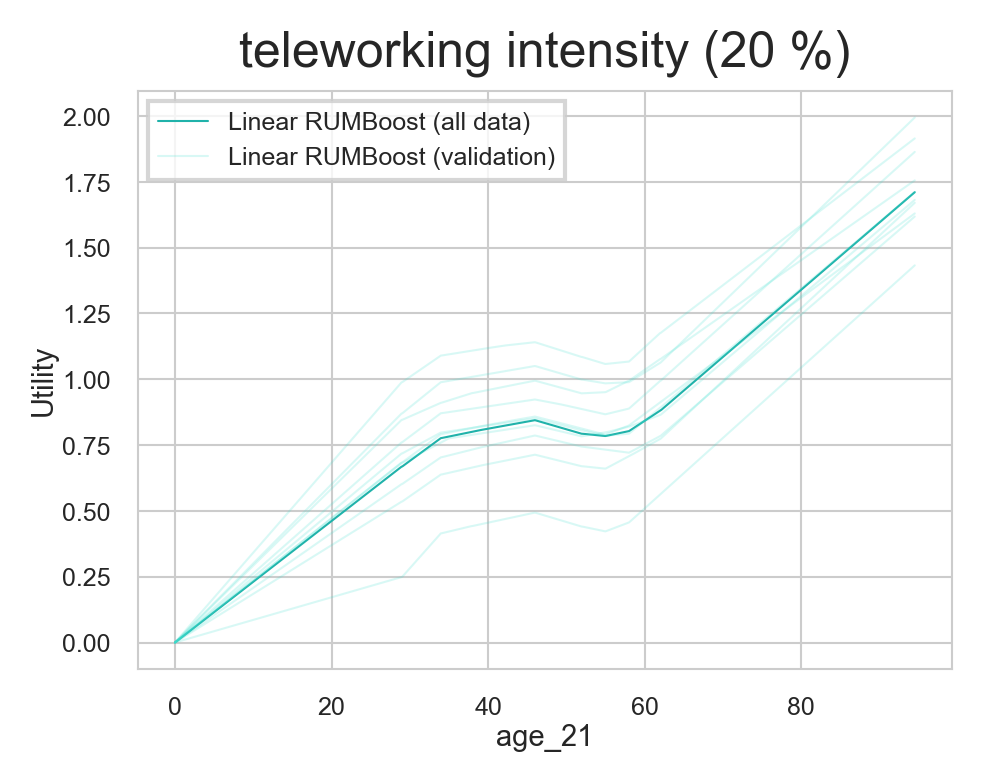

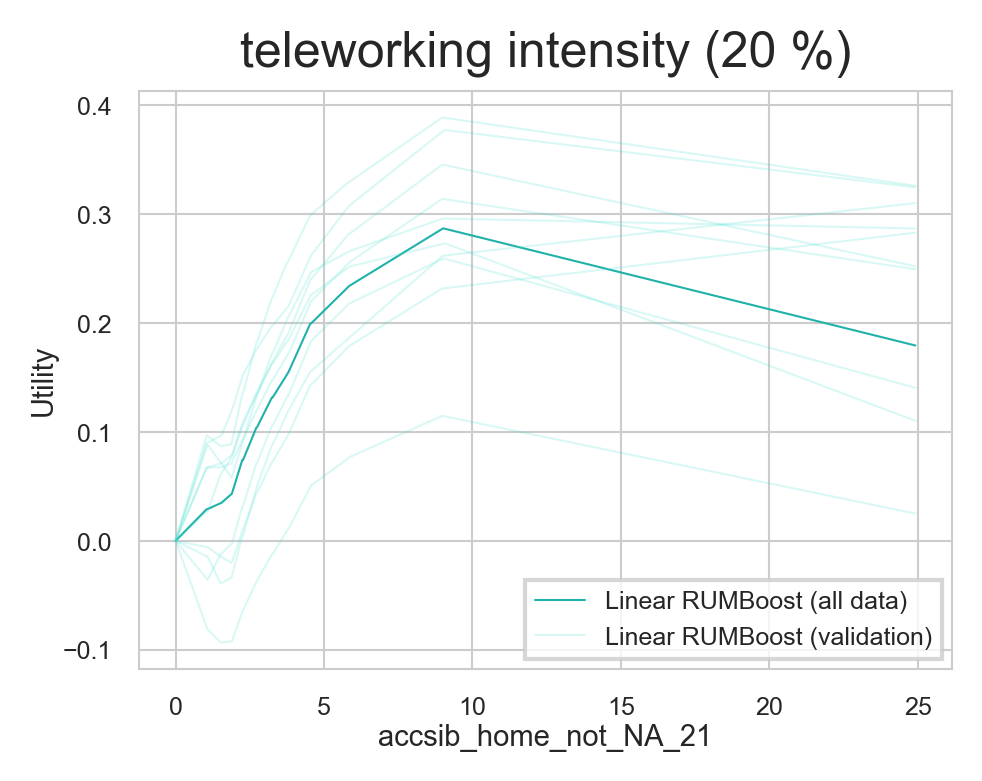

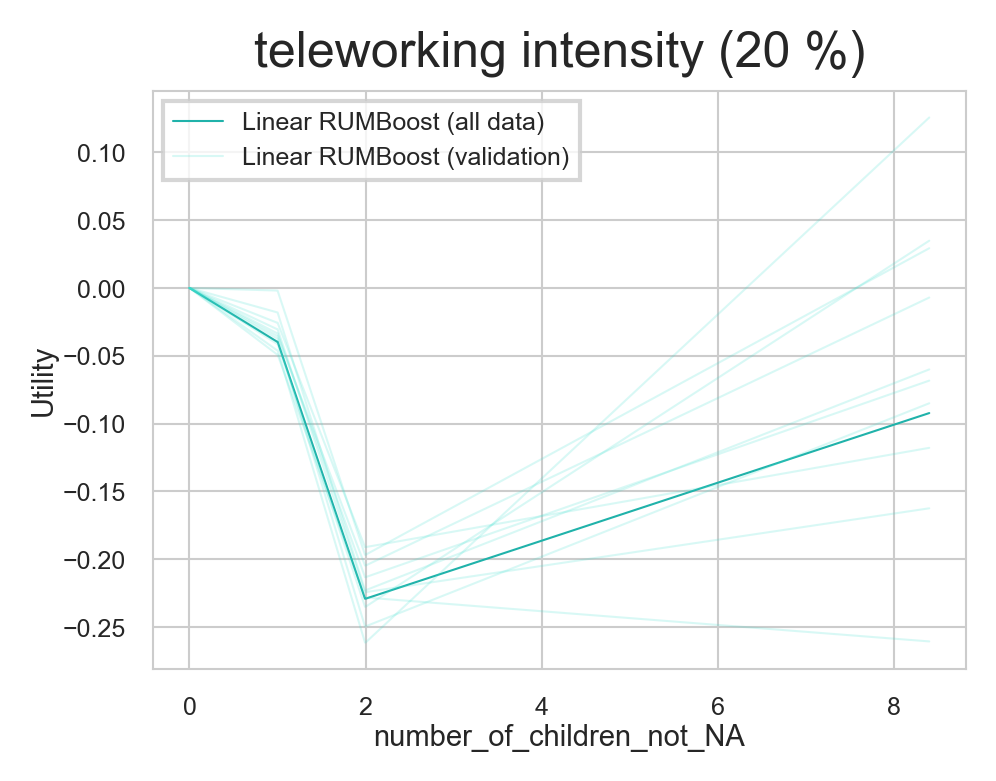

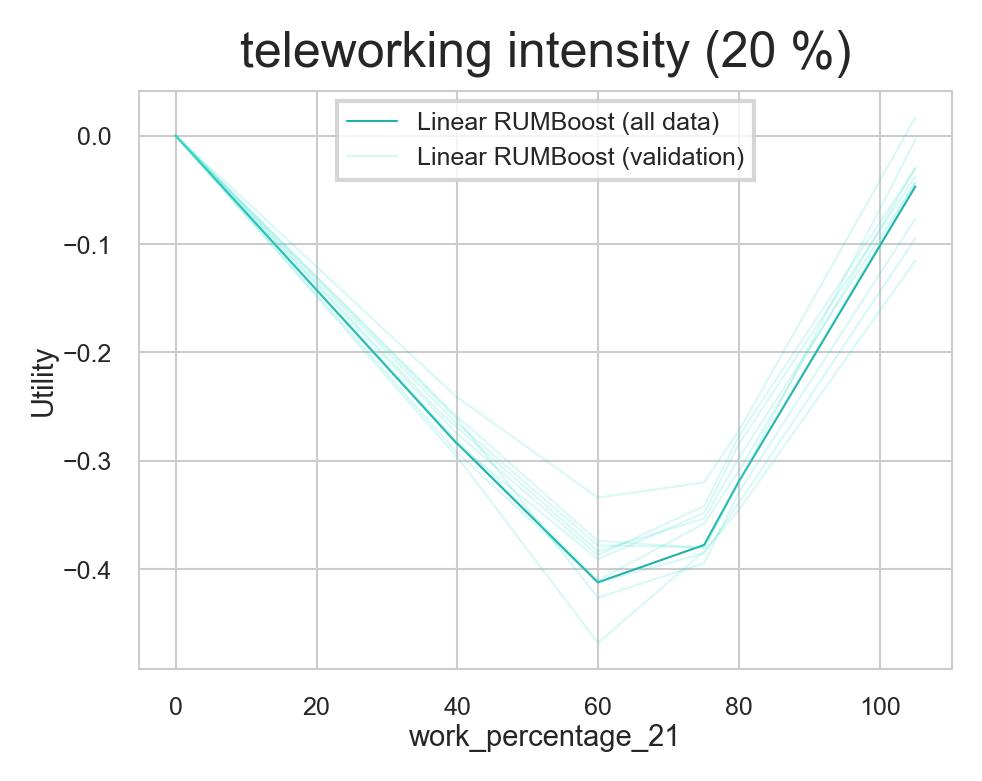

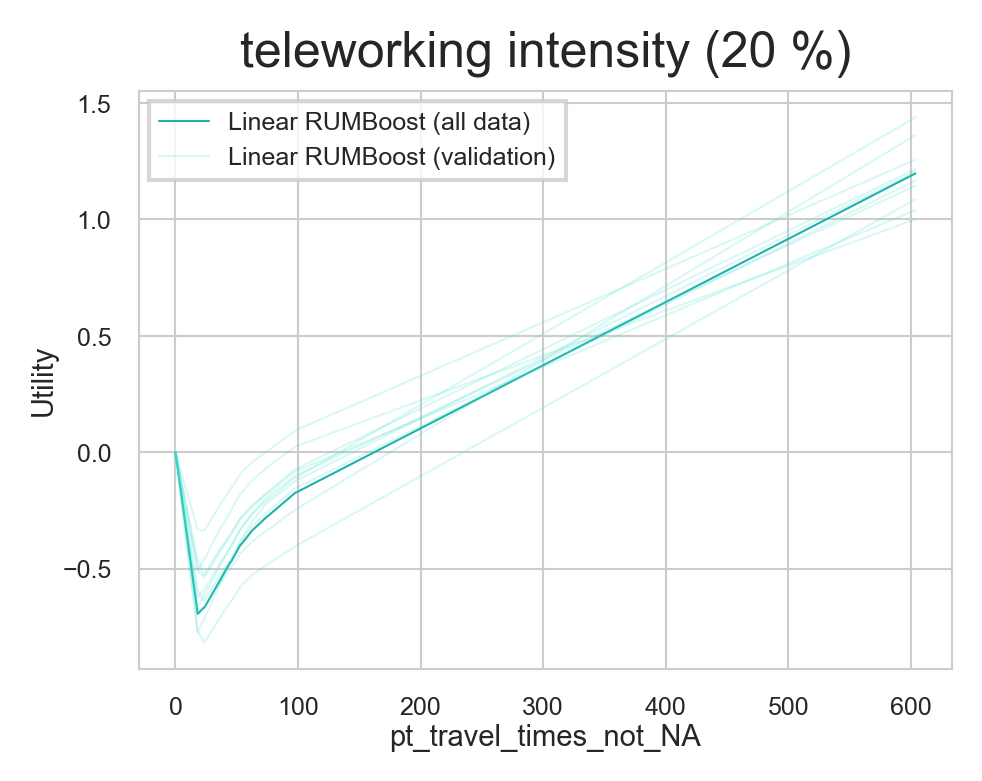

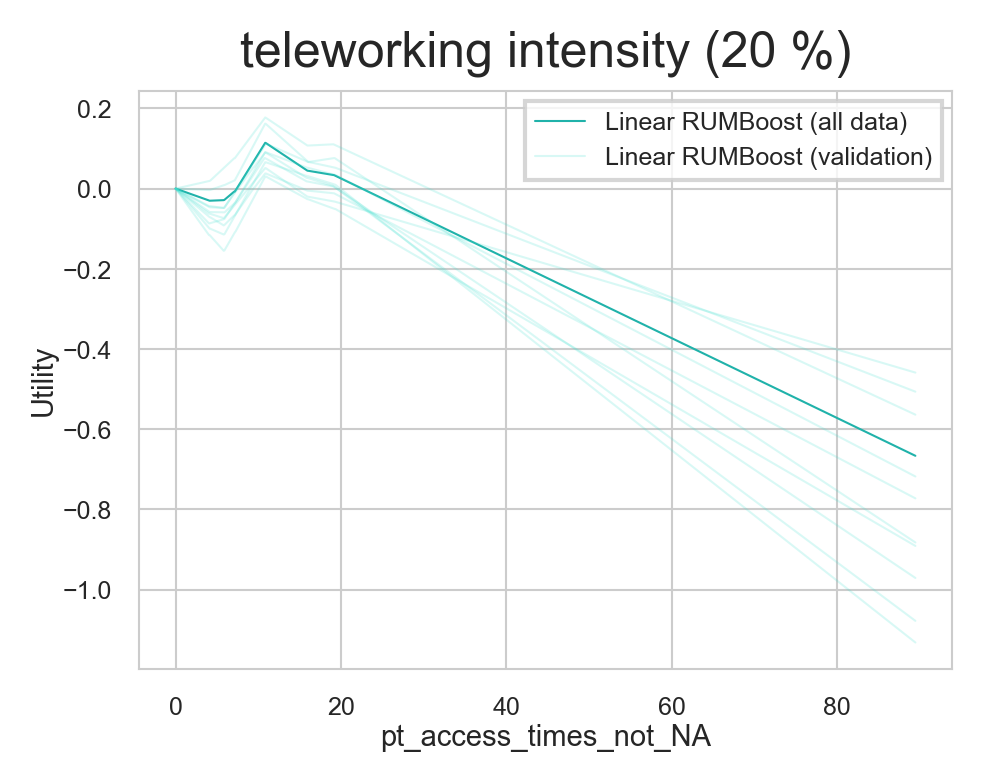

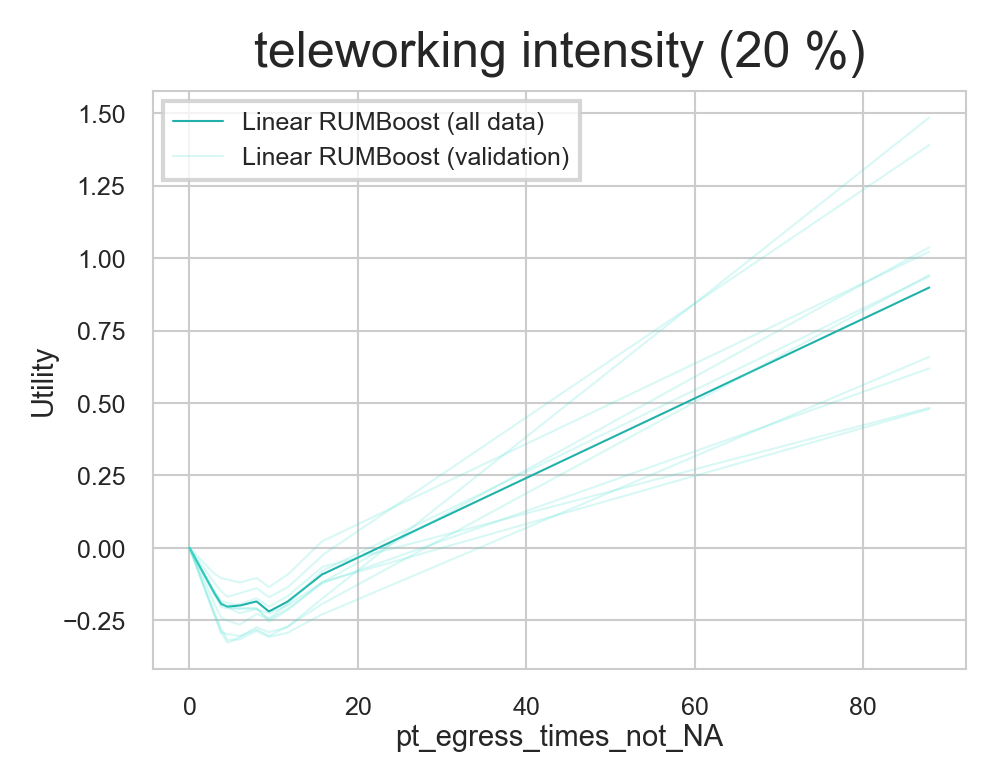

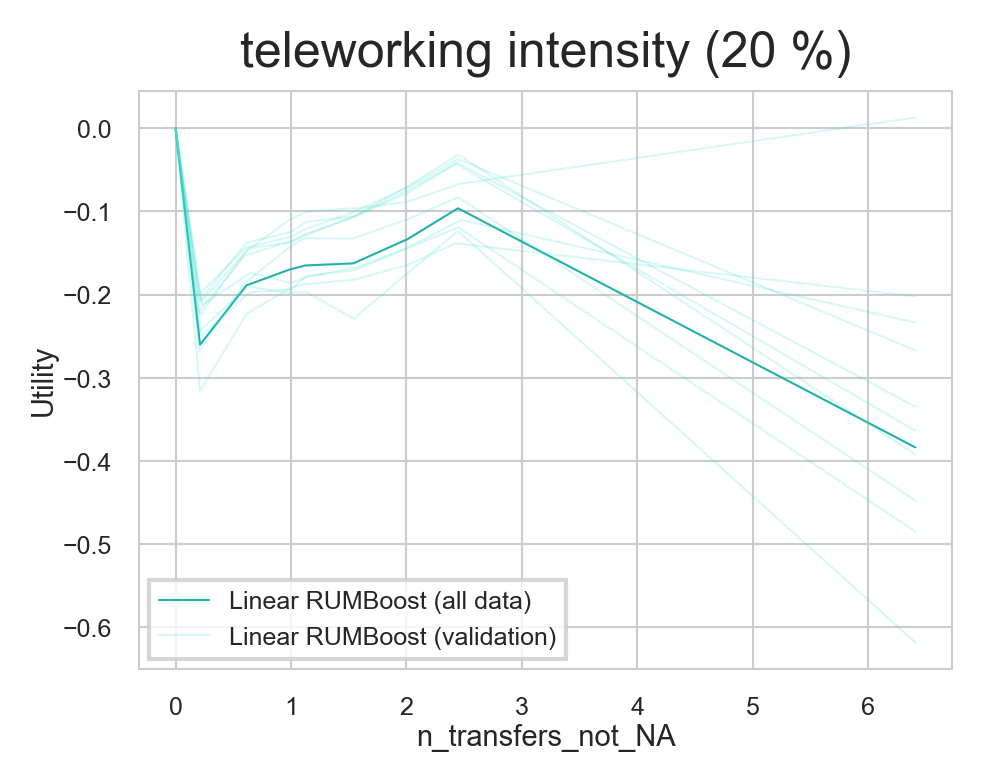

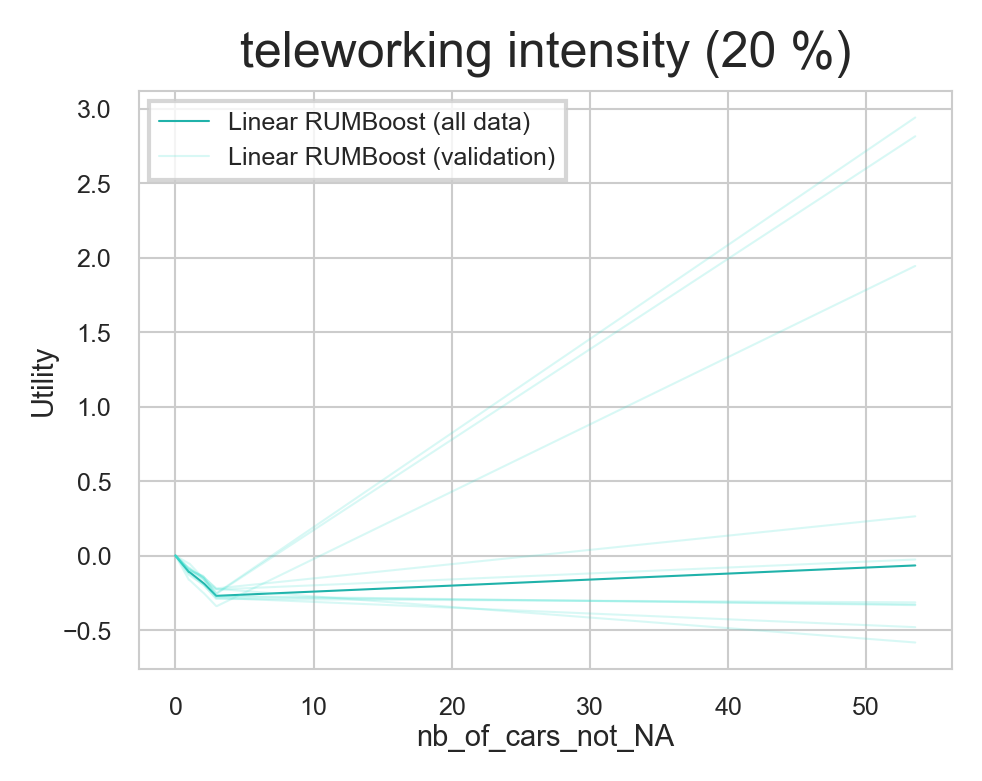

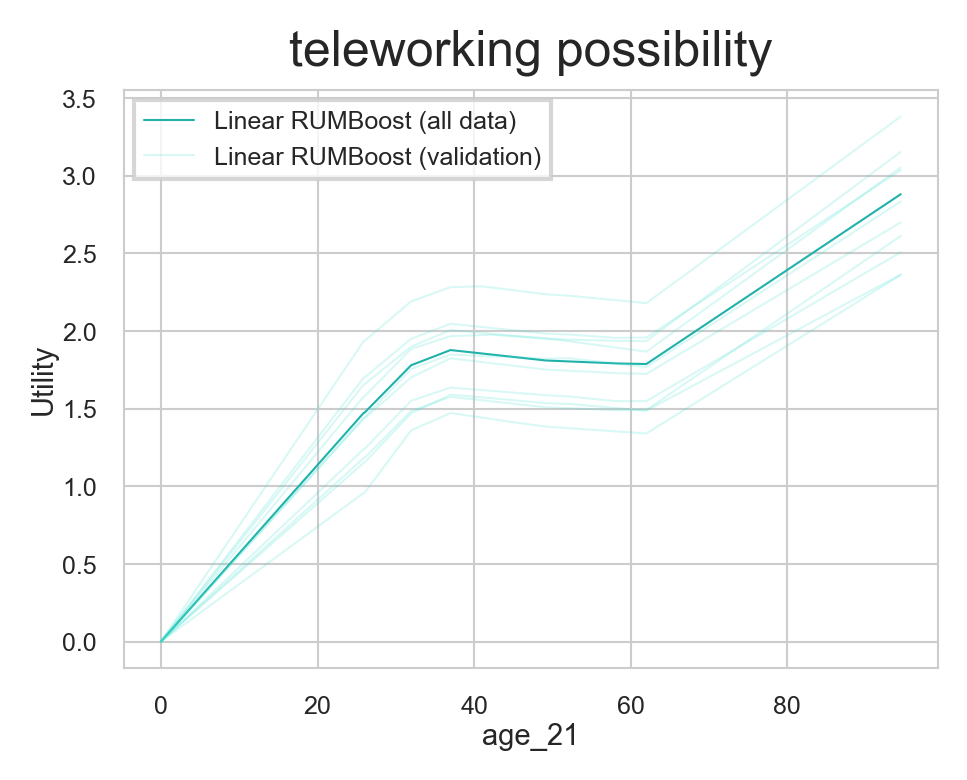

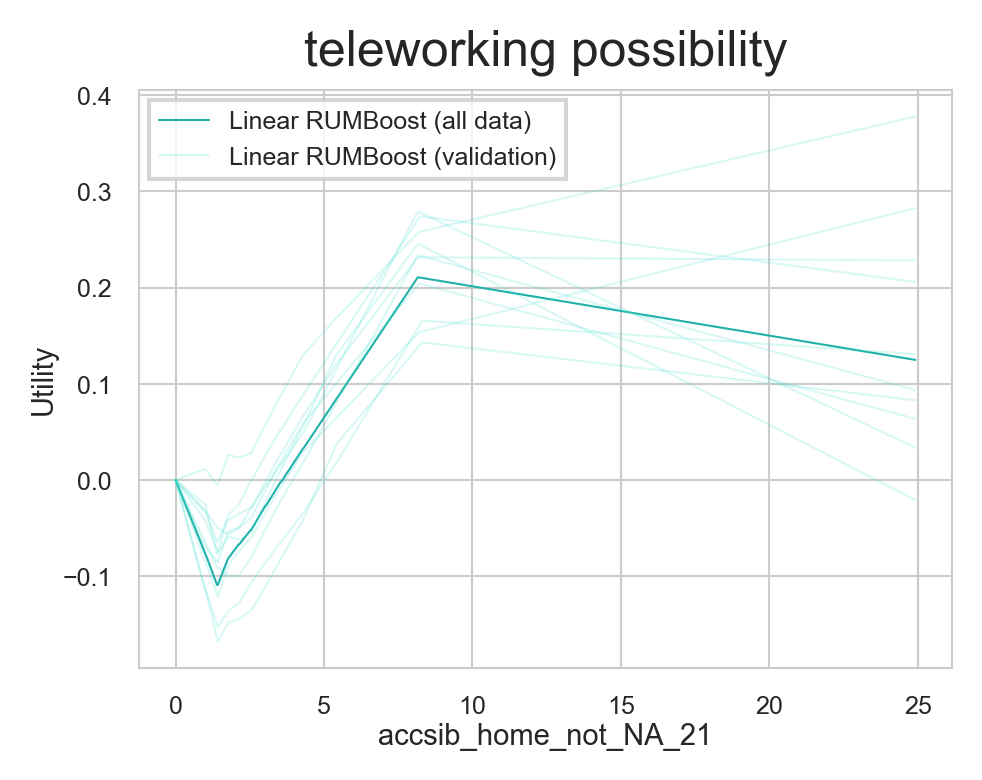

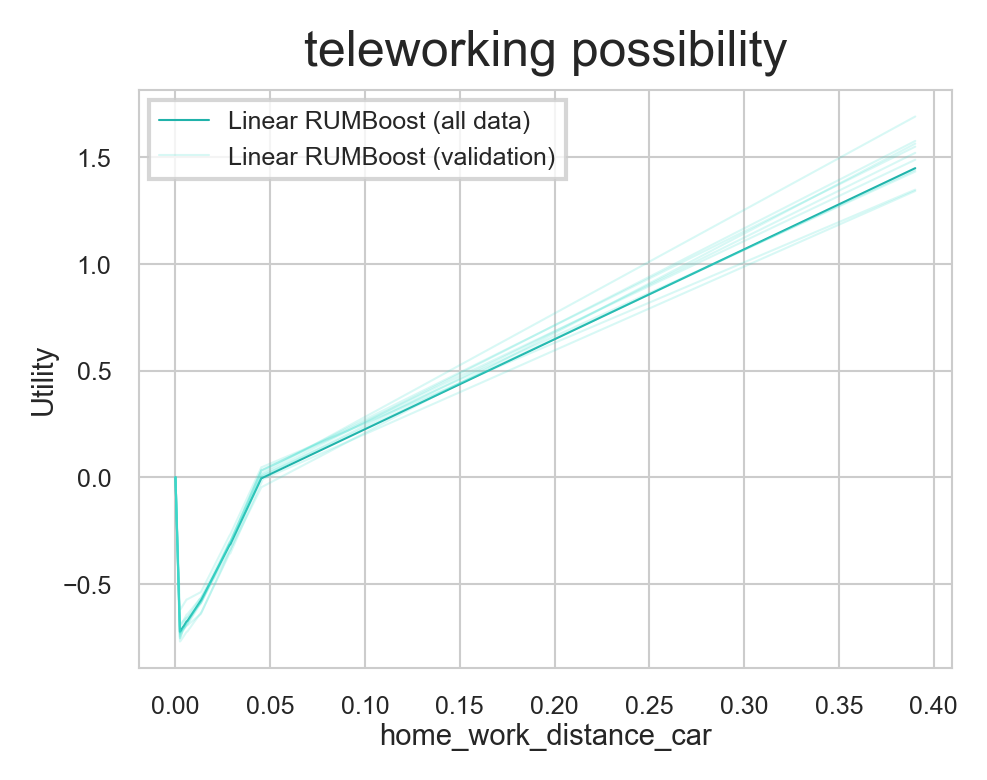

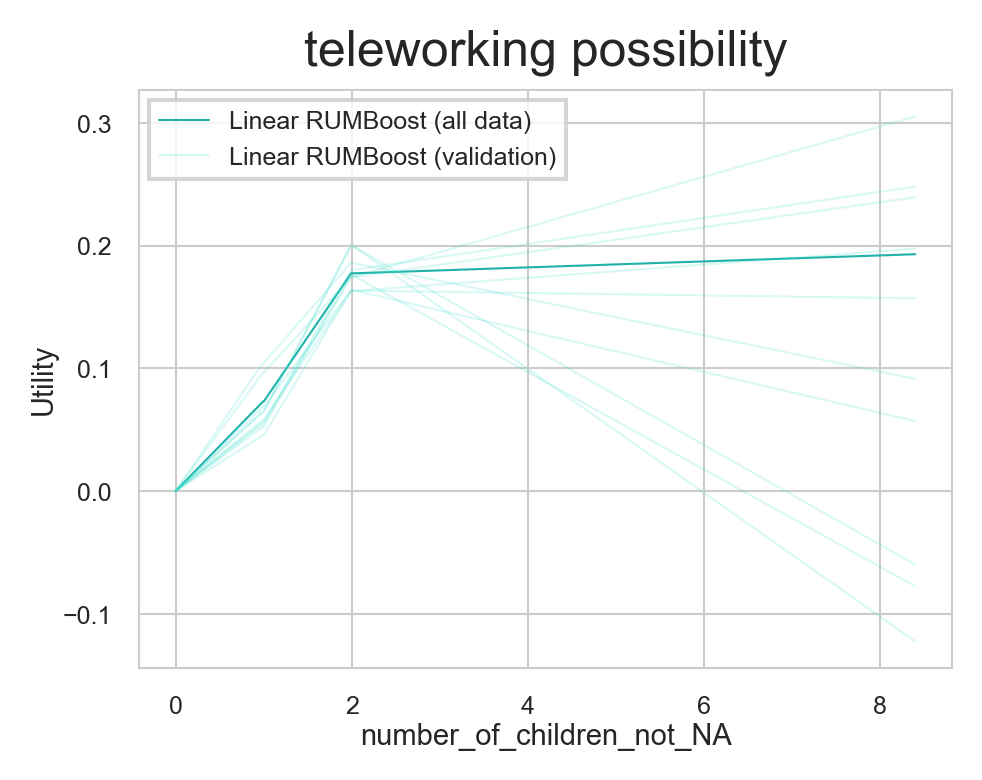

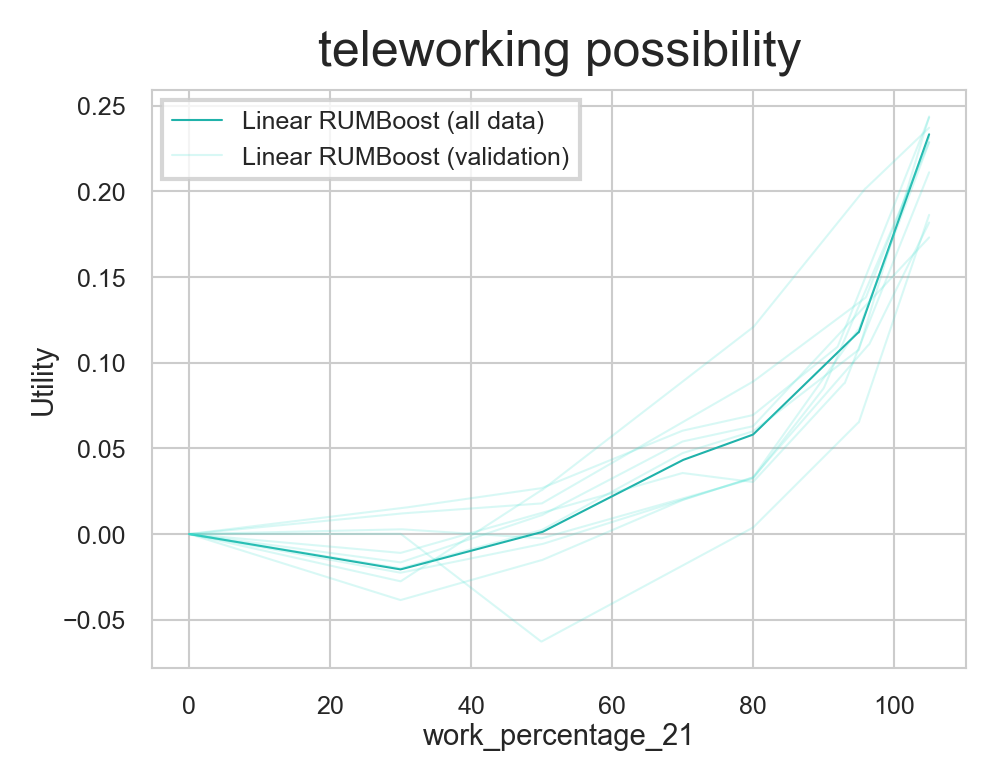

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from src.simba.mobi.choice.models.homeoffice.constants_calibration import load_and_split_dataset
from src.simba.mobi.choice.models.homeoffice.rumboost_definition import define_variables

dataset, _ = load_and_split_dataset(test_size=0)
dataset = define_variables(dataset, "telecommuting_intensity")
pd.option_context("mode.use_inf_as_na", True)
tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": "Computer Modern Roman",
    # Use 14pt font in plots, to match 10pt font in document
    "axes.labelsize": 7,
    "axes.linewidth": 0.5,
    "axes.labelpad": 1,
    "font.size": 7,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 6,
    "legend.fancybox": False,
    "legend.edgecolor": "inherit",
    "legend.borderaxespad": 0.4,
    "legend.borderpad": 0.4,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "xtick.major.pad": 0.5,
    "ytick.major.pad": 0.5,
    "grid.linewidth": 0.5,
    "lines.linewidth": 0.8,
}
sns.set_theme(font_scale=1, rc=tex_fonts)
sns.set_style("whitegrid")
title_names = ["teleworking intensity (20 %)", "teleworking possibility"]
ufs_dict = {}
for m, weights in all_weights.items():
    ufs_dict[m] = {}
    for k, (i, l) in enumerate(weights.items()):
        ufs_dict[m][i] = {}
        for f in nonlin_params_name:
            if f not in l[0].keys():
                continue
            ufs_dict[m][i][f] = {
                "xplot": np.linspace(0, 1.05 * dataset[f].max(), 1000),
                "yarr": np.array([]),
            }
            yi = []
            for weights in l:
                boost_from_param = "lin" in m
                _, y = non_lin_function(weights[f], 0, 1.05 * dataset[f].max(), 1000, boosted_from_parameter_space=boost_from_param)
                yi.append([yii - y[0] for yii in y])
            ufs_dict[m][i][f]["yarr"] = np.array(yi)


for j, i in enumerate([20, 0]):
    for f in nonlin_params_name:
        for l, m in enumerate(["rumboost_all_data", "rumboost", "lin_rumboost_all_data", "lin_rumboost"]):
            if f not in ufs_dict[m][i].keys():
                no_plot = True
                continue
            else:
                no_plot = False
            if l == 0:
                fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi = 300)
            x, y = ufs_dict[m][i][f]["xplot"], ufs_dict[m][i][f]["yarr"].mean(axis=0)

            if m == "rumboost_all_data":
                color = "indianred"
                alpha = 1
                label = "RUMBoost (all data)"
            elif m == "rumboost":
                color = "lightcoral"
                alpha = 0.2
                label = "RUMBoost (validation)"
            elif m == "lin_rumboost_all_data":
                color = "lightseagreen"
                alpha = 1
                label = "Linear RUMBoost (all data)"
            elif m == "lin_rumboost":
                color = "turquoise"
                alpha = 0.2
                label = "Linear RUMBoost (validation)"

            for k in range(ufs_dict[m][i][f]["yarr"].shape[0]):
                sns.lineplot(
                    x=x,
                    y=ufs_dict[m][i][f]["yarr"][k, :].T,
                    color=color,
                    alpha=alpha,
                    ax=ax,
                    linewidth=0.5,
                    label=label if k == 0 else None,
                )
            ax.set_title(title_names[j])
            ax.set_xlabel(f)
            ax.set_ylabel("Utility")

        if not no_plot:
            save_directory = os.path.join(results_directory, "figures")
            os.makedirs(save_directory, exist_ok=True)
            modelling_task = "intensity" if i > 0 else "possibility"
            plt.savefig(save_directory + f"/{f}_{modelling_task}.png", bbox_inches="tight")


Note for the paper:

- Plot of all 11 models for each non-linear parameter, each choice situation
- Bold line denotes model on all data, and lines with more transparency are individual models